In [1]:
import pandas as pd
import numpy as np
import sqlite3
import datetime
import sklearn
import sqlalchemy as sa
from tqdm import tqdm_notebook
import itertools
import pickle
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn import metrics

In [2]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

import operator
import gc

In [12]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

In [4]:
%matplotlib inline

---

для обучения берем только данные с 20171029 по 20171128<br>
для теста с 20171129 по 20171205

In [48]:
%%time
!mkdir -p ../../data/predictions/
train_df = pd.read_feather('../../data/combined_dataset/train_v1.fth')
test_df = pd.read_feather('../../data/combined_dataset/test_v1.fth')

CPU times: user 2.51 s, sys: 7.8 s, total: 10.3 s
Wall time: 17.7 s


In [49]:
%%time
drop_cols = ['event_id', 'user_id', 'short_date', 'event_time']
train_df.drop(columns = drop_cols, inplace = True)
test_df.drop(columns = drop_cols, inplace = True)

CPU times: user 1.39 s, sys: 3.76 s, total: 5.15 s
Wall time: 5.12 s


In [71]:
del train_df, test_df
gc.collect()

7

параметры для xgboost были подобраны в другом ноутбуке через GridSearch

In [50]:
model = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
                          gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
                          min_child_weight=1, missing=None, n_estimators=200,
                          objective='binary:logistic', reg_alpha=8, reg_lambda=1,
                          scale_pos_weight=1, seed=0, silent=True, subsample=0.6, n_jobs=16)

In [53]:
%%time
predictor = model.fit(train_df.drop('label', axis = 1), train_df['label'])

CPU times: user 5h 53min 40s, sys: 38.1 s, total: 5h 54min 18s
Wall time: 31min 11s


some sanity checks

In [56]:
train_proba = predictor.predict_proba(train_df.drop('label', axis = 1))

In [67]:
roc_auc_score(y_train, preds)

0.9832089666371764

In [69]:
roc_auc_score(y_train, preds)

0.9853628902540555

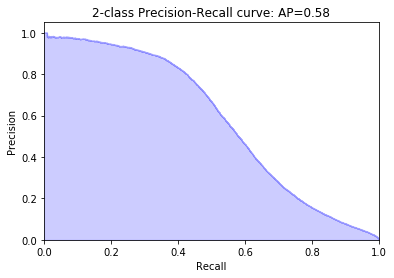

0.5797506022336302

In [68]:
y_train = [1 if x == 1 else 0 for x in train_df['label']]
preds = train_proba[:, 2]
average_precision = average_precision_score(y_train, preds)
precision, recall, thresholds = precision_recall_curve(y_train, preds)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

metrics.auc(recall, precision)

array([8.7942590e-07, 1.2060659e-06, 8.6193307e-07, ..., 9.6656277e-07,
       1.1605683e-06, 3.6948761e-05], dtype=float32)

In [41]:
sorted(test_df['short_date'].unique())

[20171129, 20171130, 20171201, 20171202, 20171203, 20171204, 20171205]

In [ ]:
score_dates = [20170]

In [17]:
train_df[:, drop_cols]

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f7d62c86d68>>
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


NameError: name 'drop_cols' is not defined

In [103]:
%%time
train_raw = pd.read_feather('../../data/prepaired_dataset/train_v2.fth')

CPU times: user 811 ms, sys: 2.19 s, total: 3.01 s
Wall time: 5.76 s


In [104]:
train_raw = train_raw.loc[train_raw.label != -1].copy()

In [105]:
rng = np.random.RandomState(seed=1)

In [106]:
uid_train, uid_val = train_test_split(sorted(train_raw['user_id'].unique()), test_size = 0.2, random_state = rng)

In [111]:
set(uid_train) & set(uid_val)

set()

In [107]:
drop_cols = ['event_id', 'user_id', 'event_time', 'short_date']

In [113]:
train_raw['short_date'].min(), train_raw['short_date'].max()

(20171029, 20171128)

In [17]:
%%time
t = train_raw.loc[train_raw['user_id'].isin(uid_train)].drop(drop_cols, axis = 1)
dtrain = xgb.DMatrix(t.drop('label', axis = 1), label=t['label'], missing=np.NAN)
t = train_raw.loc[train_raw['user_id'].isin(uid_val)].drop(drop_cols, axis = 1)
dval = xgb.DMatrix(t.drop('label', axis = 1), label=t['label'], missing=np.NAN)

CPU times: user 5.27 s, sys: 6.24 s, total: 11.5 s
Wall time: 11.5 s


In [18]:
del t, train_raw
gc.collect()

311

In [49]:
params={
    'max_depth': [3, 5], 
    'subsample': [0.4, 0.6], 
    'colsample_bytree': [0.5, 0.7], 
    'n_estimators': [150, 250],
    'reg_alpha': [0.01, 0.03] 
}

In [73]:
cv_params_list = []
def cv_get(nxt, already = []):
    global cv_params_list
    if len(nxt) == 0:
        return None
    if len(nxt) == 1:
        for k, v in nxt:
            for vv in v:
                cv_params_list.append(already + [(k, vv)])
    else:
        k, v = nxt.pop()
        for vv in v:
            already_cp = already.copy()
            already_cp.append((k, vv))
            cv_get(nxt.copy(), already_cp)
            
cv_get([(k, v) for k,v in sorted(params.items(), key = lambda x: x[0])])
len(cv_params_list)

32

In [81]:
print('XGBoost with grid search and early stopping')
# 
evallist = [(dtrain, 'train'), (dval, 'eval')]
num_round = 250
models = []

for chunk_params in tqdm_notebook([{k:v for k, v in x} for x in cv_params_list]):
    i_params = chunk_params.copy()
    i_params['n_jobs'] = 16
    i_params['objective'] = 'binary:logistic'
    bst = xgb.train(i_params, dtrain, num_round, evallist, verbose_eval=100, early_stopping_rounds = 20)
    models.append((chunk_params, bst))

XGBoost with grid search and early stopping


HBox(children=(IntProgress(value=0, max=32), HTML(value='')))

[0]	train-error:0.003682	eval-error:0.003629
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
[100]	train-error:0.003036	eval-error:0.003088
Stopping. Best iteration:
[97]	train-error:0.003045	eval-error:0.003068

[0]	train-error:0.003682	eval-error:0.003629
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
[100]	train-error:0.003021	eval-error:0.003094
Stopping. Best iteration:
[87]	train-error:0.003049	eval-error:0.003066

[0]	train-error:0.003682	eval-error:0.003629
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
Stopping. Best iteration:
[64]	train-error:0.002855	eval-error:0.003021

[0]	train-error:0.003677	eval-error:0.00364
Multiple eval metrics have been passed: 'eval-error' will be used for ear

Will train until eval-error hasn't improved in 20 rounds.
[100]	train-error:0.00305	eval-error:0.003069
Stopping. Best iteration:
[89]	train-error:0.003077	eval-error:0.003038

[0]	train-error:0.003682	eval-error:0.003629
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
[100]	train-error:0.003035	eval-error:0.00312
Stopping. Best iteration:
[90]	train-error:0.003058	eval-error:0.00311

[0]	train-error:0.003625	eval-error:0.003613
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
Stopping. Best iteration:
[58]	train-error:0.002861	eval-error:0.002994

[0]	train-error:0.003675	eval-error:0.003627
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
Stopping. Best iteration:
[61]	train-error:0.002846	eval-error

In [86]:
from sklearn.metrics import roc_auc_score

In [124]:
aucs = []
for n, (_, m) in enumerate(models):
    auc = roc_auc_score(dval.get_label(), m.predict(dval))
    aucs.append(auc)
    print(n, auc)

0 0.9704324466873154
1 0.9703810300955136
2 0.9710333956722436
3 0.9709251706344146
4 0.9704324466873154
5 0.9703810300955136
6 0.9710333956722436
7 0.9709251706344146
8 0.9705974924834623
9 0.9704145120931789
10 0.9712938856512467
11 0.9704445573355049
12 0.9705974924834623
13 0.9704145120931789
14 0.9712938856512467
15 0.9704445573355049
16 0.9711788472703512
17 0.9713224253094613
18 0.9716453218776682
19 0.9714534164702587
20 0.9711788472703512
21 0.9713224253094613
22 0.9716453218776682
23 0.9714534164702587
24 0.9713626103041888
25 0.9711393336439436
26 0.9712842783473541
27 0.9719205963627728
28 0.9713626103041888
29 0.9711393336439436
30 0.9712842783473541
31 0.9719205963627728


In [97]:
bst.get_score()

{'age_diff': 194,
 'amnt2chnls': 162,
 'amount': 163,
 'cat_new_ip': 47,
 'cat_new_prov': 37,
 'cdf_s_127': 43,
 'cdf_s_129': 43,
 'cdf_s_130': 66,
 'cdf_s_133': 31,
 'cdf_s_134': 47,
 'cdf_s_135': 26,
 'channel_indicator_desc_is_MOBILEAPI': 8,
 'channel_indicator_desc_is_WEBAPI': 9,
 'client_age': 254,
 'client_region': 85,
 'cumulative_sum_total': 144,
 'data_i_120': 67,
 'data_i_154': 120,
 'event_day': 56,
 'event_day_is_weekend': 2,
 'event_hour': 78,
 'event_hour_night': 6,
 'ip_isp': 117,
 'know_recip_card_age': 8,
 'know_recip_power': 75,
 'krp_pow2': 31,
 'log_amount': 53,
 'one_region': 25,
 'op_type': 36,
 'recip_card_age': 18,
 'relative': 12,
 'transfer_age_diff': 57,
 'transfer_for_relative': 5,
 'transfer_know_recip_squared': 15,
 'user_id_CRM': 1,
 'user_id_MBK': 8,
 'user_id_digit_only': 7}

In [121]:
folder = '../../data/models/simple_baseline/v1/'
!mkdir -p $folder

In [122]:
with open(folder + 'models.pkl', 'wb') as f:
    pickle.dump(models, f)

In [134]:
models[27][0]

{'colsample_bytree': 0.7,
 'max_depth': 5,
 'n_estimators': 150,
 'reg_alpha': 0.03,
 'subsample': 0.6}

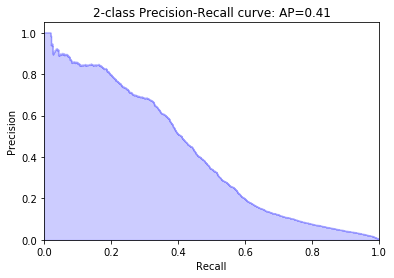

0.41220502375777257

In [133]:
y_val = dval.get_label()
preds = models[27][1].predict(dval)
average_precision = average_precision_score(y_val, preds)
precision, recall, thresholds = precision_recall_curve(y_val, preds)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

metrics.auc(recall, precision)